## 1. Introduction
In this notebook, I implement an Intent Classification model. The system receives user utterances that have been transcribed from speech and must correctly infer the user’s underlying intent (e.g., checking an application status, applying for a service, or booking an appointment).

The major challenge I hope to solve:
- Noisy speech-to-text transcripts
- Code-switching between Kinyarwanda, English, and borrowed terms
- Informal and paraphrased expressions
- Limited labeled data for low-resource languages, particularly Kinyarwanda

The goal is to build a model that is robust, generalizes well across linguistic variations,
![](https://github.com/daunsid/voice-ai/blob/main/diagram-export-1-19-2026-12_08_54-PM.png?raw=true)

## 2. Aim and Objectives
Aim

To develop and evaluate a machine learning–based intent classification model that can accurately predict user intent from multilingual and noisy voice transcripts, with a focus on low-resource language settings.

Objectives
- Design an intent classification pipeline suitable for Voice AI systems
- Handle code-switching and informal language in user utterances
- Explore modeling choices that support multilingual and low-resource scenarios
- Evaluate model performance with attention to robustness and reliability
- Discuss production, monitoring, and ethical considerations relevant to public-sector use


## 3. Approach Taken

- Data Preparation
- Modeling Approach
- Training and Evaluation
- Analysis and Discussion
- Production and Ethics Considerations

Modelling Intuition: Why XLM-R for Multilingual Intent Classification

I base my modeling approach on XLM-R (XLM-RoBERTa), as introduced in the paper [Unsupervised Cross-lingual Representation Learning at Scale](https://arxiv.org/abs/1911.02116)

Core Intuition

The key idea behind XLM-R is that XLM-R has learned shared semantic structure across languages becasue it has been trained on massive multilingual corpora using a masked language modeling (MLM) objective, the model understands representations that align semantically similar phrases across languages becasue accoding to the authors the goal is to  improve cross-lingual
language understanding (XLU) especially for low resourced languages which makes it suitable for this task becasue:

1. Kinyarwanda is low-resource
2. User utterances often involve code-switching
3. The same intent appears in many paraphrased surface forms
4. XLM-R allows intent knowledge learned from higher-resource languages (e.g., English) to transfer to Kinyarwanda and mixed utterances.



In [1]:
# for the sake of reproducibility let's define some important configs

import torch
import random
import numpy as np

SEED = 42

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# PATH
from pathlib import Path

DATASET = Path('/kaggle/input/intent-data')

# MODELLING

MODEL_NAME = 'xlm-roberta-base'

## Data Preparation


#### Load the Dataset



In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv(DATASET/"voiceai_intent_dataset (1).csv")

# Basic inspection
df.head()


,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00159,2025-11-07T15:32:00,whatsapp_voice_note,feature_phone,Western,en,What are the requirements for ID replacement?,0.902,9,requirements_information,train
1,utt_00501,2025-11-12T10:41:00,voice_call,android,Kigali,en,Am I eligible to apply for ESIA?,0.644,7,service_eligibility,train
2,utt_00397,2025-11-28T17:58:00,ivr,web,Eastern,mixed,Help me reset password yanjye.,0.964,9,reset_password_login_help,train
3,utt_00156,2025-11-25T19:52:00,voice_call,web,Southern,en,I submitted my aplikasiyo but I can't see the ...,0.911,2,check_application_status,train
4,utt_00322,2025-11-24T00:46:00,voice_call,feature_phone,Eastern,en,I want to start a new application for birth ce...,0.810,10,start_new_application,train


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   utterance_id      700 non-null    object 
 1   timestamp         700 non-null    object 
 2   channel           700 non-null    object 
 3   device_type       700 non-null    object 
 4   region            700 non-null    object 
 5   language          700 non-null    object 
 6   utterance_text    700 non-null    object 
 7   asr_confidence    700 non-null    float64
 8   duration_seconds  700 non-null    int64  
 9   intent            700 non-null    object 
 10  split             700 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 60.3+ KB


The two column I actually care about are the `utterance_text` and `intent` so I will select this two calls for further exploration

In [4]:
# # Focus on columns relevant for language and intent analysis
df = df[[
    "utterance_id",
    "utterance_text",
    "intent",
    "language",
    "split"
]]



# Drop rows with missing values
df = df.dropna(
    subset=[
        "utterance_id",
        "utterance_text",
        "intent",
        "language",
        "split"
    ]
)

# Reset index after dropping rows
df = df.reset_index(drop=True)

df.head()


,utterance_id,utterance_text,intent,language,split
0,utt_00159,What are the requirements for ID replacement?,requirements_information,en,train
1,utt_00501,Am I eligible to apply for ESIA?,service_eligibility,en,train
2,utt_00397,Help me reset password yanjye.,reset_password_login_help,mixed,train
3,utt_00156,I submitted my aplikasiyo but I can't see the ...,check_application_status,en,train
4,utt_00322,I want to start a new application for birth ce...,start_new_application,en,train


In [5]:
len(df)

700

let's explore the intent distribution to examine how many samples belong to each intent to help undertand how modelling should proceed and be able to handle for class imbalanced problem

In [6]:
# Intent distribution
intent_counts = df["intent"].value_counts()
intent_counts


intent
check_application_status            117
requirements_information             86
start_new_application                71
payment_help                         54
reset_password_login_help            51
complaint_or_support_ticket          51
fees_information                     50
appointment_booking                  47
service_eligibility                  45
update_application_details           39
speak_to_agent                       38
cancel_or_reschedule_appointment     29
document_upload_help                 22
Name: count, dtype: int64

Next is overall language distribution to examine how many utterances belong to each language category becasue even with a multilingual model, severe underrepresentation of a language in this case `rw` can lead to poor generalization

In [7]:
language_counts = df["language"].value_counts()
language_counts


language
rw       306
en       201
mixed    193
Name: count, dtype: int64

<Axes: title={'center': 'Overall Language Distribution'}, xlabel='Language', ylabel='Number of Utterances'>

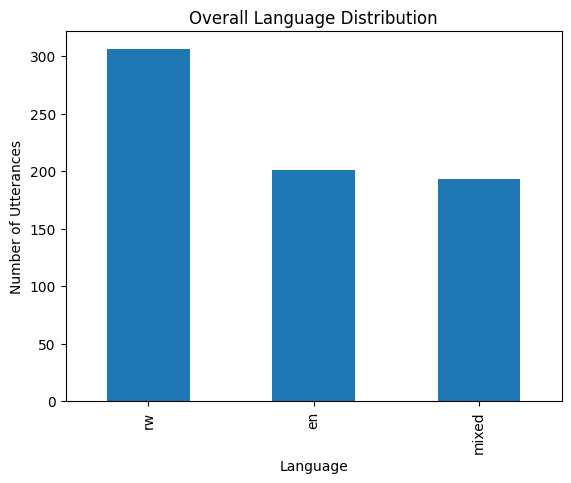

In [8]:
language_counts.plot(
    kind="bar",
    title="Overall Language Distribution",
    xlabel="Language",
    ylabel="Number of Utterances"
)


Also let's check the language distribution by intent to inspec whether certain intents aredominated by one language although hopefully this will not be a problem because 

In [9]:
intent_language_counts = (
    df.groupby(["intent", "language"])
      .size()
      .unstack(fill_value=0)
)

intent_language_counts.head()


language,en,mixed,rw
intent,,,
appointment_booking,17,13,17
cancel_or_reschedule_appointment,11,7,11
check_application_status,32,38,47
complaint_or_support_ticket,12,15,24
document_upload_help,6,8,8


<Axes: title={'center': 'Language Distribution per Intent'}, xlabel='intent', ylabel='Number of Utterances'>

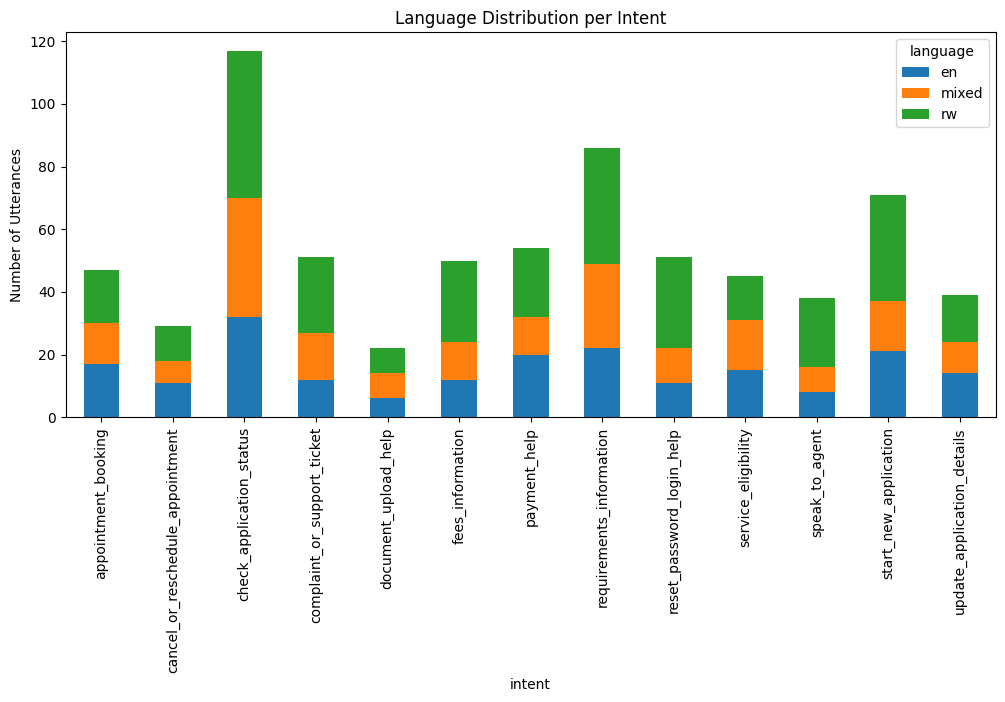

In [10]:
intent_language_counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 5),
    title="Language Distribution per Intent",
    ylabel="Number of Utterances"
)


Let's do some deep dive into kinyarwanda and mixed utterances to get a clue on the linguistic patterns of `kw` and mixed utterance of `en` and `kw` 

In [11]:
df_rw_mixed = df[df["language"].isin(["rw", "mixed"])]

df_rw_mixed["language"].value_counts()


language
rw       306
mixed    193
Name: count, dtype: int64

In [12]:
df_rw_mixed[["utterance_text", "intent", "language"]].sample(
    5, random_state=SEED
)


,utterance_text,intent,language
640,Ndashaka kumenya aho application number igeze.,check_application_status,rw
108,Mwashobora kungufasha gutangiza passport?,start_new_application,rw
322,Help me book rendez-vous for land title.,appointment_booking,mixed
253,Natanze case ariko sinzi aho igeze.,check_application_status,rw
328,Ndashaka kuvugana n'umukozi.,speak_to_agent,rw


Let's also check the language distribution to verify whether the predefined split column preserves language diversity

In [13]:
split_language_counts = (
    df.groupby(["split", "language"])
      .size()
      .unstack(fill_value=0)
)

split_language_counts


language,en,mixed,rw
split,,,
test,21,9,39
train,159,164,238
val,21,20,29


<Axes: title={'center': 'Language Distribution Across Dataset Splits'}, xlabel='split', ylabel='Number of Utterances'>

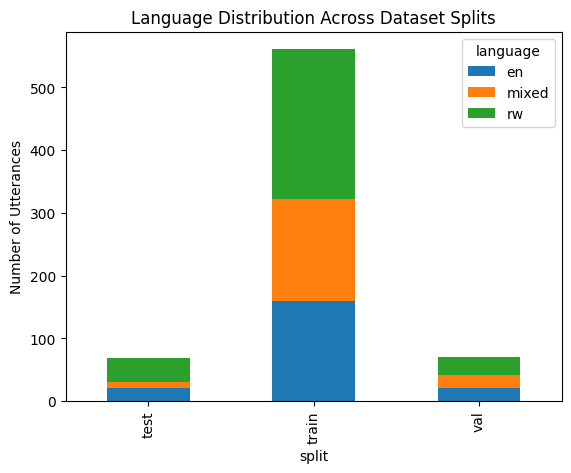

In [14]:
split_language_counts.plot(
    kind="bar",
    stacked=True,
    title="Language Distribution Across Dataset Splits",
    ylabel="Number of Utterances"
)


Lastly, we will check the utterance text length, distribution across lang and whether any outliers exist.
This helps to determine a suitable seq length and padding strategy

In [15]:
# Compute utterance length in characters
df["char_length"] = df["utterance_text"].apply(len)

# Summary stats
df["char_length"].describe()


count    700.000000
mean      43.091429
std       10.164185
min       21.000000
25%       35.000000
50%       43.000000
75%       50.000000
max       71.000000
Name: char_length, dtype: float64

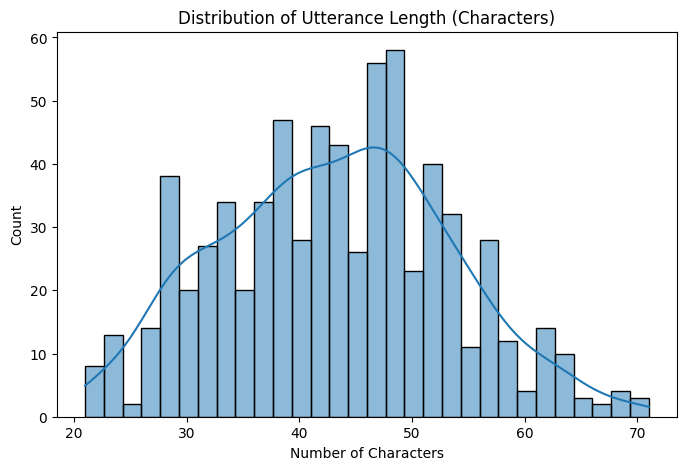

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df["char_length"], bins=30, kde=True)
plt.title("Distribution of Utterance Length (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()


Observation: 

### Data Preprocessing

Having in mind that XLM-R was pretrained on raw multilingual web text, so aggresive cleaning is not neccessary, Also I will try to preserve ASR artifacts i.e misspellings, informal phrases.
For Tokenization I will use the standard `XLMRTokenizer` which andles multilingual subwords, short uttterances.

*Text Cleaning* This includes lowercasing the utterances, striping leading/trailing spaces and removing empty or null utterances

In [17]:
# Minimal text preprocessing
def preprocess_text(text: str) -> str:
    text = text.lower().strip()
    return text

df["utterance_text"] = df["utterance_text"].apply(preprocess_text)

# Drop empty utterances just in case
df = df[df["utterance_text"].str.strip() != ""].reset_index(drop=True)
df.head()


,utterance_id,utterance_text,intent,language,split,char_length
0,utt_00159,what are the requirements for id replacement?,requirements_information,en,train,45
1,utt_00501,am i eligible to apply for esia?,service_eligibility,en,train,32
2,utt_00397,help me reset password yanjye.,reset_password_login_help,mixed,train,30
3,utt_00156,i submitted my aplikasiyo but i can't see the ...,check_application_status,en,train,53
4,utt_00322,i want to start a new application for birth ce...,start_new_application,en,train,56


In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["intent_id"] = label_encoder.fit_transform(df["intent"])
num_labels = len(label_encoder.classes_)
num_labels


13

***Tokenization:***

I will be using the official tokenizer of the roberta model from the `XLMRobertaTokenizer` class provided through the transformer library. It's provide a unique juice for a problem becasue of how it tokenizes word. It breaks every text into sub word units this is especially useful for us becasue it allows the tokenizer to handle rare word and phrases well.
example: `"Checka niba application yanjye yarangiye" → ['▁Check', 'a', '▁ni', 'ba', '▁application', '▁yan', 'j', 'ye', '▁ya', 'rang', 'iye']`
Also this class abstract other parts steps like normalization and conversion to model inputs.

This can be done in two simple steps:
- Initialize XLM-R tokenizer

- Convert utterances into:

    - input_ids

    - attention_mask

- Use max sequence length = 64, since voice utterances are short

In [19]:
from transformers import XLMRobertaTokenizer


tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [20]:
# Example tokenization
en_sample_text = df["utterance_text"].iloc[0]
en_input_tokens = tokenizer(en_sample_text, padding="max_length", truncation=True, max_length=64)
en_sample_tokens = tokenizer.tokenize(en_sample_text)

In [21]:
kw_sample_text = df["utterance_text"].iloc[389]
kw_input_ids = tokenizer(kw_sample_text, padding="max_length", truncation=True, max_length=64)
kw_sample_tokens = tokenizer.tokenize(kw_sample_text)

In [22]:
print(f"text: {en_sample_text}")
print(f"tokens: {en_sample_tokens}")

text: what are the requirements for id replacement?
tokens: ['▁what', '▁are', '▁the', '▁requirements', '▁for', '▁id', '▁replace', 'ment', '?']


Common English words appear as single subwords, Morphology is captured via splits: `replacement replace + ment` This is expected because English appears extensively in pretraining data

In [24]:
print(f"text: {kw_sample_text}")
print(f"tokens: {kw_sample_tokens}")

text: amafaranga ya gusimbuza indangamuntu ni angahe?
tokens: ['▁ama', 'fa', 'ranga', '▁ya', '▁', 'gusi', 'mbu', 'za', '▁in', 'dang', 'am', 'untu', '▁ni', '▁ang', 'a', 'he', '?']


Kinyarwanda words are split into smaller subwords, These subwords are phonologically and morphologically consistent, `Amafaranga: Ama + fa + ranga` `indangamuntu: in + dang + am + untu`

In [ ]:
mx_sample_text = 'Checka niba application yanjye yarangiye'#df["utterance_text"].iloc[2]
mx_input_ids = tokenizer(mx_sample_text, padding="max_length", truncation=True, max_length=64)
mx_sample_tokens = tokenizer.tokenize(mx_sample_text)

In [ ]:
print(f"text: {mx_sample_text}")
print(f"tokens: {mx_sample_tokens}")

`Checka → Check + a`

- English root + local slang suffix

`niba: ni + ba`

`yanjye: yan + j + ye`

`yarangiye: ya + rang + iye`

In [ ]:
inputs_tokens

putting all the previous data loading and preprocessing steps together the pytorch `Dataset` class allows us to 

***Label Encoding***: Convert intent into numeric IDs for PyTorch, Keep label_encoder to map back to original intents later

In [ ]:
set(df["intent_id"].tolist())

In [25]:
train_df = df[df["split"] == "train"].reset_index(drop=True)
test_df = df[df["split"] == "test"].reset_index(drop=True)
val_df = df[df["split"] == "val"].reset_index(drop=True)


In [26]:
train_df.head()

,utterance_id,utterance_text,intent,language,split,char_length,intent_id
0,utt_00159,what are the requirements for id replacement?,requirements_information,en,train,45,7
1,utt_00501,am i eligible to apply for esia?,service_eligibility,en,train,32,9
2,utt_00397,help me reset password yanjye.,reset_password_login_help,mixed,train,30,8
3,utt_00156,i submitted my aplikasiyo but i can't see the ...,check_application_status,en,train,53,2
4,utt_00322,i want to start a new application for birth ce...,start_new_application,en,train,56,11


In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(train_df["intent"])
train_df["intent_id"] = label_encoder.transform(train_df["intent"])
test_df["intent_id"] = label_encoder.transform(test_df['intent'])
val_df["intent_id"] = label_encoder.transform(val_df['intent'])

num_labels = len(label_encoder.classes_)
num_labels


13

In [28]:
class_dict = {
    cls: idx
    for idx, cls in enumerate(label_encoder.classes_)
}
class_dict

{'appointment_booking': 0,
 'cancel_or_reschedule_appointment': 1,
 'check_application_status': 2,
 'complaint_or_support_ticket': 3,
 'document_upload_help': 4,
 'fees_information': 5,
 'payment_help': 6,
 'requirements_information': 7,
 'reset_password_login_help': 8,
 'service_eligibility': 9,
 'speak_to_agent': 10,
 'start_new_application': 11,
 'update_application_details': 12}

In [29]:
import torch
from torch.utils.data import Dataset

class IntentDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

    def get_classes(self,):
        return {
            cls: idx
            for idx, cls in enumerate(label_encoder.classes_)
        }

# Example instantiation
train_dataset = IntentDataset(
    texts=train_df["utterance_text"].tolist(),
    labels=train_df["intent_id"].tolist(),
    tokenizer=tokenizer
)

val_dataset = IntentDataset(
    texts=val_df["utterance_text"].tolist(),
    labels=val_df["intent_id"].tolist(),
    tokenizer=tokenizer
)

test_dataset = IntentDataset(
    texts=test_df["utterance_text"].tolist(),
    labels=test_df["intent_id"].tolist(),
    tokenizer=tokenizer
)

# Check a sample
train_dataset[0]


{'input_ids': tensor([    0,  2367,   621,    70, 96679,   100,  3447, 91995,   674,    32,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(7)}

## Modeling Overview

We will model this problem as a `multiclass text classification` problem, where the goal is to predict a single intent label from a short, multilingual voice utterance.

Given:
- Input: token utterance (`inputs_ids`, `attention_mask`)
- Output: one intent label (e.g `check_application_status`)


![](https://github.com/daunsid/voice-ai/blob/main/layer.png?raw=true)

In [30]:
import torch
import torch.nn as nn
from transformers import XLMRobertaModel

class XLMRIntentClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.1):
        super().__init__()
        
        self.encoder = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(
            self.encoder.config.hidden_size,
            num_labels
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss, logits

        return logits


2026-01-19 13:21:34.143589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768828894.357494      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768828894.419428      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768828894.918406      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768828894.918436      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768828894.918439      55 computation_placer.cc:177] computation placer alr

In [45]:

model = XLMRIntentClassifier(
    model_name=MODEL_NAME,
    num_labels=13,
)

In [46]:
model

XLMRIntentClassifier(
  (encoder): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

## Training Configuration & Optimization

At this stage, the goal is to fine-tune XLM-R for intent classification

I will fine-tune the entire XLM-R model end-to-end using cross-entropy loss for the mean time 9this will further be extended to also consider weighted loss), optimizing for intent classification accuracy

I will use the `AdamW` optimizer which was used in the `XLM-R` paper


In [33]:
from torch.optim import AdamW

for learning rate:
- XLM-R encoder	2e-5
- Classification head	2e-5

Given the short sequence I used a batch size `16` for traiing and `32` for validation and training will be done on Kaggle's `P100`

In [34]:
from transformers import get_linear_schedule_with_warmup


In [47]:
# device setup
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [36]:
loss_fn = nn.CrossEntropyLoss()


In [37]:
config = {
    "model_name": "xlm-roberta-base",
    "max_length": 64,
    "batch_size": 16,
    "eval_batch_size": 32,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "num_epochs": 5,
    "warmup_ratio": 0.1,
    "dropout": 0.1,
    "gradient_clipping": 1.0,
}


In [38]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'])
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'])
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'])


In [39]:
device

device(type='cpu')

Training Loop

Optimizer & Scheduler Setup

In [48]:
# model = model.to(device)
optimizer = AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"]
)

total_steps = len(train_dataloader) * config["num_epochs"]
warmup_steps = int(config["warmup_ratio"] * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


In [49]:
def train_step(batch, model, optimizer, scheduler):
    model.train()

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    optimizer.zero_grad()

    loss, logits = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )

    loss.backward()
    torch.nn.utils.clip_grad_norm_(
        model.parameters(),
        config["gradient_clipping"]
    )

    optimizer.step()
    scheduler.step()

    return loss.item()


In [50]:
def eval_step(batch, model):
    model.eval()

    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(logits, dim=1)

    return preds, labels


In [51]:
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, val_loader, config):
    model.to(device)

    for epoch in range(config["num_epochs"]):
        train_losses = []

        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")

        for batch in tqdm(train_loader, desc="Training"):
            loss = train_step(batch, model, optimizer, scheduler)
            train_losses.append(loss)

        avg_train_loss = np.mean(train_losses)
        print(f"Avg Train Loss: {avg_train_loss:.4f}")

        # Validation
        all_preds, all_labels = [], []

        for batch in tqdm(val_loader, desc="Validation"):
            preds, labels = eval_step(batch, model)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
        print(f"Validation Accuracy: {val_accuracy:.4f}")


In [52]:
import os


train_model(model, train_dataloader, val_dataloader, config)


Epoch 1/5


Training: 100%|██████████| 36/36 [00:09<00:00,  3.75it/s]


Avg Train Loss: 2.6590


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.77it/s]


Validation Accuracy: 0.2286

Epoch 2/5


Training: 100%|██████████| 36/36 [00:08<00:00,  4.09it/s]


Avg Train Loss: 2.5035


Validation: 100%|██████████| 5/5 [00:00<00:00, 24.13it/s]


Validation Accuracy: 0.3571

Epoch 3/5


Training: 100%|██████████| 36/36 [00:08<00:00,  4.08it/s]


Avg Train Loss: 2.3398


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.50it/s]


Validation Accuracy: 0.4714

Epoch 4/5


Training: 100%|██████████| 36/36 [00:08<00:00,  4.06it/s]


Avg Train Loss: 1.9958


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.54it/s]


Validation Accuracy: 0.6286

Epoch 5/5


Training: 100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


Avg Train Loss: 1.7848


Validation: 100%|██████████| 5/5 [00:00<00:00, 23.31it/s]

Validation Accuracy: 0.6429


In [ ]:
device

## Evaluation

The performance is evaluated on the provided test data. I use the following metrics for the evaluation:


In [54]:
import numpy as np
import torch

def run_evaluation(model, dataloader):
    model.eval()

    all_preds = []
    all_labels = []
    # all_languages = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            # languages = batch["language"]

            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # all_languages.extend(languages)

    return (
        np.array(all_preds),
        np.array(all_labels),
        #np.array(all_languages)
    )
preds, labels = run_evaluation(model, test_dataloader)

In [55]:
preds

array([ 3,  7,  7,  7,  3,  7,  6,  7,  3,  9,  3, 11,  7,  6, 11,  7,  7,
        8,  8,  3,  7, 11,  6,  7,  2,  7, 11,  3,  2,  2,  3,  2, 11,  2,
       11,  2,  3,  8, 12,  5,  1,  8, 11, 12,  7,  2, 11,  1,  2,  3,  7,
        5,  8,  2,  8, 12,  2,  2,  3,  6, 11, 11,  8,  7,  3,  1, 11,  8,
        2])

In [56]:
labels

array([ 6,  7,  9,  7,  7,  9,  6,  7,  3,  9,  3,  3,  7,  6, 11,  7,  7,
        6,  8,  3,  6,  0,  5,  5,  2,  5,  0, 11,  2,  2,  3,  2, 11,  2,
        0,  2,  4, 10, 10,  5,  1,  8, 11,  4,  9,  2,  0,  1,  2, 10,  7,
        5,  8,  2,  8, 12,  2,  2, 12,  6, 11, 11, 10,  9, 12,  1, 11,  8,
       12])

In [57]:
from sklearn.metrics import accuracy_score, f1_score

def compute_overall_metrics(preds, labels):
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }
overall_metrics = compute_overall_metrics(preds, labels)
overall_metrics


{'accuracy': 0.6231884057971014, 'macro_f1': 0.48609684629751515}

In [58]:
test_df

,utterance_id,utterance_text,intent,language,split,char_length,intent_id
0,utt_00547,"nishyuye ariko ntibyemejwe, nafasha?",payment_help,rw,test,36,6
1,utt_00099,amabwiriza yo gusaba driving license ni ayahe?,requirements_information,rw,test,46,7
2,utt_00503,ese gusimbuza indangamuntu iba isabwa n’abantu...,service_eligibility,rw,test,61,9
3,utt_00694,nkeneye ibisabwa byo gukora visa yo kuza.,requirements_information,rw,test,41,7
4,utt_00063,nkeneye ibisabwa byo gukora passport.,requirements_information,rw,test,37,7
...,...,...,...,...,...,...,...
64,utt_00072,nashaka guhindura amakuru muri case yanjye.,update_application_details,rw,test,43,12
65,utt_00107,can i change the appointment time?,cancel_or_reschedule_appointment,en,test,34,1
66,utt_00271,help me gutangira application ya id replacement.,start_new_application,mixed,test,48,11
67,utt_00436,"otp ntabwo igeze, what can i do?",reset_password_login_help,mixed,test,32,8


In [59]:
preds_df = test_df.copy()

In [60]:
preds_df['preds_id'] = preds

In [61]:
preds_df

,utterance_id,utterance_text,intent,language,split,char_length,intent_id,preds_id
0,utt_00547,"nishyuye ariko ntibyemejwe, nafasha?",payment_help,rw,test,36,6,3
1,utt_00099,amabwiriza yo gusaba driving license ni ayahe?,requirements_information,rw,test,46,7,7
2,utt_00503,ese gusimbuza indangamuntu iba isabwa n’abantu...,service_eligibility,rw,test,61,9,7
3,utt_00694,nkeneye ibisabwa byo gukora visa yo kuza.,requirements_information,rw,test,41,7,7
4,utt_00063,nkeneye ibisabwa byo gukora passport.,requirements_information,rw,test,37,7,3
...,...,...,...,...,...,...,...,...
64,utt_00072,nashaka guhindura amakuru muri case yanjye.,update_application_details,rw,test,43,12,3
65,utt_00107,can i change the appointment time?,cancel_or_reschedule_appointment,en,test,34,1,1
66,utt_00271,help me gutangira application ya id replacement.,start_new_application,mixed,test,48,11,11
67,utt_00436,"otp ntabwo igeze, what can i do?",reset_password_login_help,mixed,test,32,8,8


Language-Aware Metrics

In [64]:
def compute_language_metrics(preds, labels, languages):
    results = {}

    for lang in np.unique(languages):
        idx = languages == lang
        results[lang] = {
            "accuracy": accuracy_score(labels[idx], preds[idx]),
            "macro_f1": f1_score(labels[idx], preds[idx], average="macro"),
            "support": idx.sum()
        }

    return results
language_metrics = compute_language_metrics(preds, labels, preds_df['language'])

In [63]:
results

{'en': {'accuracy': 0.7619047619047619,
  'macro_f1': 0.5833333333333333,
  'support': np.int64(21)},
 'mixed': {'accuracy': 0.7777777777777778,
  'macro_f1': 0.6428571428571429,
  'support': np.int64(9)},
 'rw': {'accuracy': 0.5128205128205128,
  'macro_f1': 0.4151709401709402,
  'support': np.int64(39)}}

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

lang_df = pd.DataFrame(language_metrics).T.reset_index()
lang_df.rename(columns={"index": "language"}, inplace=True)

lang_df


,language,accuracy,macro_f1,support
0,en,0.761905,0.583333,21.0
1,mixed,0.777778,0.642857,9.0
2,rw,0.512821,0.415171,39.0


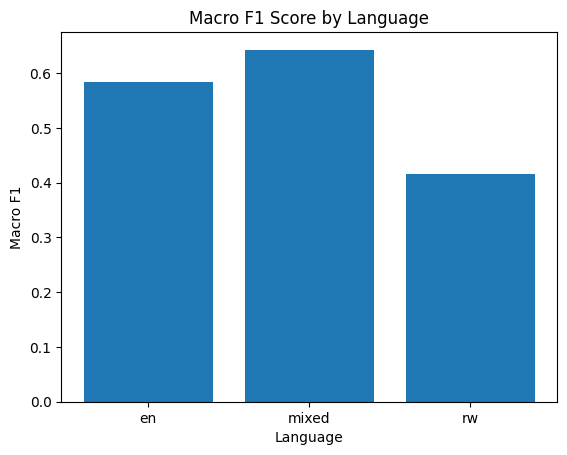

In [66]:
plt.figure()
plt.bar(lang_df["language"], lang_df["macro_f1"])
plt.title("Macro F1 Score by Language")
plt.xlabel("Language")
plt.ylabel("Macro F1")
plt.show()


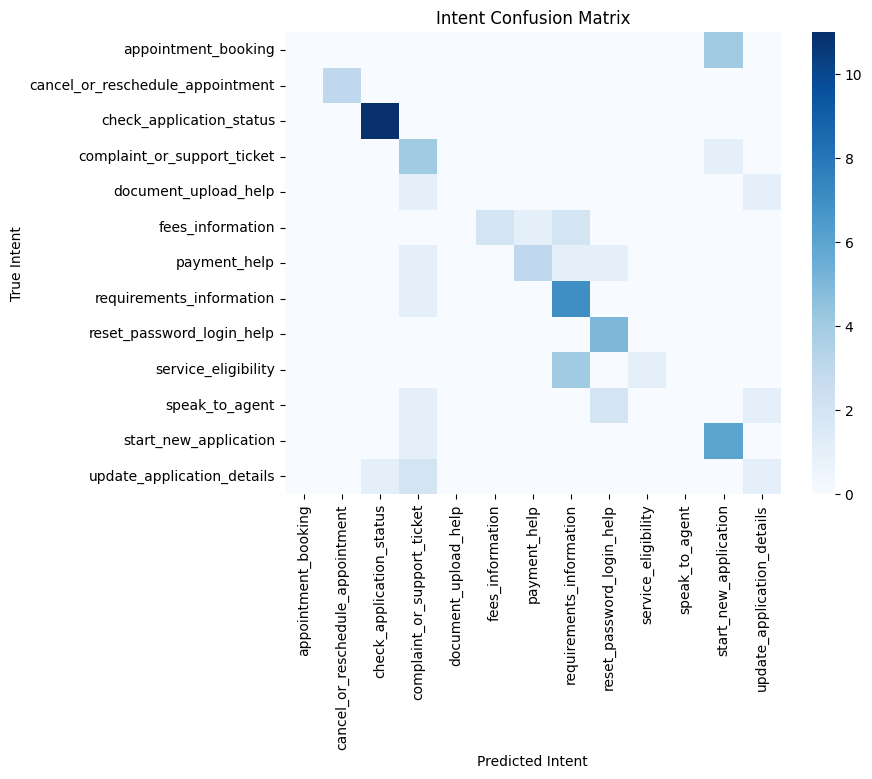

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
intent_names = test_dataset.get_classes().keys()
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    xticklabels=intent_names,
    yticklabels=intent_names,
    annot=False,
    cmap="Blues"
)
plt.xlabel("Predicted Intent")
plt.ylabel("True Intent")
plt.title("Intent Confusion Matrix")
plt.show()


Save Model

In [70]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "intent2id": class_dict,
        "config": config
    },
    "xlmr_intent_classifier.pt"
)
